# CoxTime

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models import CoxCC
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

In [114]:
df_train = pd.read_excel("SimData_Transplant_Ver2.0.xls", index_col = False, header=0)
df_train = df_train[df_train['Age_Tx'] >= 18] 

In [115]:
le = LabelEncoder()
df_train["Gender"] = le.fit_transform(df_train["Gender"])
df_train["Bloodtype"] = le.fit_transform(df_train["Bloodtype"])
df_train["Donor_Bloodtype"] = le.fit_transform(df_train["Donor_Bloodtype"])
df_train["Inpt_attx"] = le.fit_transform(df_train["Inpt_attx"])
df_train["Donor_Sex"] = le.fit_transform(df_train["Donor_Sex"])
df_train["Donor_DCD"] = le.fit_transform(df_train["Donor_DCD"])

In [116]:
df_train

,Gender,Bloodtype,Inpt_attx,Donor_Sex,Donor_Bloodtype,Donor_DCD,Waittime,Age_Tx,Donor_Age,TransplantBMI,Donor_BMI,MELD,MELDNA,Time,Cens
0,1,3,2,1,2,0,1,54.291739,45.379636,24.712049,21.369229,22.939930,22.931727,2019.866962,0
1,1,0,0,1,3,0,157,59.817111,60.516200,28.887631,25.408853,18.985337,21.381548,1815.128065,1
2,0,0,0,1,0,0,49,63.198440,30.989861,26.869533,24.902931,23.694392,26.243047,396.556200,0
3,1,3,2,0,2,0,81,28.845900,41.142174,27.411596,35.396950,11.375444,8.545730,1326.259556,0
4,1,3,0,0,3,0,620,55.523918,49.138937,24.530967,29.372668,26.835544,29.211865,605.043515,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,0,0,0,0,0,638,66.768544,62.181956,29.624822,30.205990,17.050266,14.632579,2578.443555,0
3996,1,0,0,1,0,0,146,61.143847,57.131994,24.984602,18.078771,13.369472,10.730959,2642.791337,1
3997,1,0,2,0,0,0,60,41.818547,39.402747,31.146902,24.720377,19.096785,22.031645,3091.405566,0
3998,1,0,0,1,0,0,152,36.732881,18.422351,36.196905,22.702255,16.906836,14.620845,1833.622662,0


In [91]:
count = 0
for i in df_train["Cens"]:
    count +=1
    if i == 1:
        if df_train.iloc[count,13] > 12000:
            print(df_train.iloc[count,13])        

13816.146137622909
13589.426961668467
13482.920818994982
15934.300545419868
13850.706597910534
14226.589069780224
12638.895293613174


In [92]:
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [48]:
X_train = df_train.drop(['Donor_Sex', 'Gender', 'Donor_DCD', 'Donor_BMI', 'Donor_Age'], axis=1)

In [49]:
X_test = df_test.drop(['Donor_Sex', 'Gender', 'Donor_DCD', 'Donor_BMI', 'Donor_Age'], axis=1)
X_val = df_val.drop(['Donor_Sex', 'Gender', 'Donor_DCD', 'Donor_BMI', 'Donor_Age'], axis=1)

In [13]:
X_train

,Bloodtype,Inpt_attx,Donor_Bloodtype,Waittime,Age_Tx,TransplantBMI,MELD,MELDNA,Time,Cens
0,3,2,2,1,54.291739,24.712049,22.939930,22.931727,2019.866962,0
3,3,2,2,81,28.845900,27.411596,11.375444,8.545730,1326.259556,0
4,3,0,3,620,55.523918,24.530967,26.835544,29.211865,605.043515,0
7,0,0,0,36,63.126194,28.211870,14.401054,19.627470,1799.694792,0
10,0,0,0,407,64.985867,26.675671,18.406648,24.709508,761.236777,0
...,...,...,...,...,...,...,...,...,...,...
3991,3,0,3,69,59.196285,34.628199,14.331877,14.327984,103.679540,0
3993,3,0,3,120,43.149585,28.336020,9.835697,9.840107,1111.433603,0
3994,3,1,3,51,72.402884,27.234865,20.468026,20.461963,434.050558,1
3997,0,2,0,60,41.818547,31.146902,19.096785,22.031645,3091.405566,0


In [14]:
cols_standardize = ['Waittime', 'Age_Tx', 'TransplantBMI', 'MELD', 'MELDNA']
cols_leave = ['Bloodtype', 'Inpt_attx', 'Donor_Bloodtype']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [15]:
x_train = x_mapper.fit_transform(X_train).astype('float32')
x_val = x_mapper.transform(X_val).astype('float32')
x_test = x_mapper.transform(X_test).astype('float32')

In [102]:
x_train

array([[-0.7624951 ,  0.22069603, -0.5118742 , ...,  3.        ,
         2.        ,  2.        ],
       [-0.37603277, -2.1653295 , -0.02526142, ...,  3.        ,
         2.        ,  2.        ],
       [ 2.2277572 ,  0.336236  , -0.5445155 , ...,  3.        ,
         0.        ,  3.        ],
       ...,
       [-0.52095616,  1.9189562 , -0.05711843, ...,  3.        ,
         1.        ,  3.        ],
       [-0.47747913, -0.94890004,  0.6480544 , ...,  0.        ,
         2.        ,  0.        ],
       [-0.10067835, -2.4518983 , -0.79767346, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [16]:
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['Time'].values, df['Cens'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
Time_test, Cens_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

In [18]:
val.shapes()

((640, 8), ((640,), (640,)))

In [19]:
x_train[0]

array([-0.7624951 ,  0.22069603, -0.5118742 ,  0.42929128,  0.30720448,
        3.        ,  2.        ,  2.        ], dtype=float32)

# Neural net
We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. The net required by CoxTime is slightly different than most of the other methods as it also take time and an additional input argument. We have therefore crated the MLPVanillaCoxTime class that is a suitable version of tt.practical.MLPVanilla. This class also removes the options for setting out_features and output_bias as they should be 1 and False, respectively.

In [20]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

# Training the model
To train the model we need to define an optimizer. You can choose any torch.optim optimizer, but here we instead use one from tt.optim as it has some added functionality. We use the Adam optimizer, but instead of choosing a learning rate, we will use the scheme proposed by Smith 2017 to find a suitable learning rate with model.lr_finder. See this post for an explanation.

We also set labtrans which connects the output nodes of the network the the label transform of the durations. This is only useful for prediction and does not affect the training procedure.

In [22]:
model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)

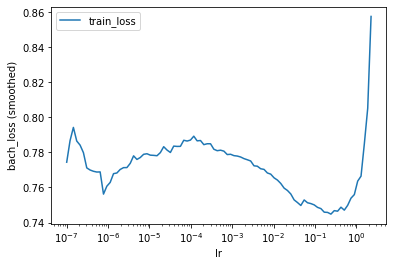

In [23]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [24]:
lrfinder.get_best_lr()

0.02420128264794396

The learning rate is high in general case, so we decrease it to 0.01

In [25]:
model.optimizer.set_lr(0.01)

In [26]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [27]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

0:	[0s / 0s],		train_loss: 0.7862,	val_loss: 0.7073
1:	[0s / 0s],		train_loss: 0.7130,	val_loss: 0.7056
2:	[0s / 0s],		train_loss: 0.7041,	val_loss: 0.7045
3:	[0s / 0s],		train_loss: 0.6977,	val_loss: 0.7124
4:	[0s / 0s],		train_loss: 0.7050,	val_loss: 0.7296
5:	[0s / 0s],		train_loss: 0.6751,	val_loss: 0.7268
6:	[0s / 0s],		train_loss: 0.6983,	val_loss: 0.7304
7:	[0s / 0s],		train_loss: 0.6830,	val_loss: 0.7151
8:	[0s / 0s],		train_loss: 0.6686,	val_loss: 0.7181
9:	[0s / 0s],		train_loss: 0.6864,	val_loss: 0.7212
10:	[0s / 0s],		train_loss: 0.6804,	val_loss: 0.7200
11:	[0s / 0s],		train_loss: 0.6870,	val_loss: 0.7199
12:	[0s / 0s],		train_loss: 0.6713,	val_loss: 0.7266
Wall time: 393 ms


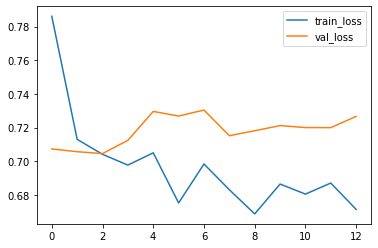

In [28]:
_ = log.plot()

In [30]:
model.partial_log_likelihood(*val).mean()

-5.525832653045654

# Prediction
For evaluation we first need to obtain survival estimates for the test set. This can be done with model.predict_surv which returns an array of survival estimates, or with model.predict_surv_df which returns the survival estimates as a dataframe.

However, as Cox-Time is semi-parametric, we first need to get the non-parametric baseline hazard estimates with compute_baseline_hazards.

Note that for large datasets the sample argument can be used to estimate the baseline hazard on a subset.

In [31]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)

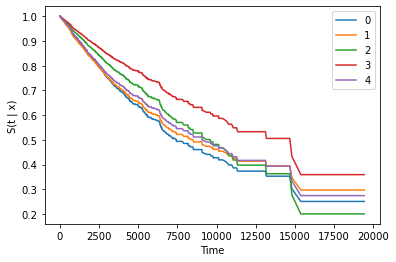

In [32]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

# Evaluation
We can use the EvalSurv class for evaluation the concordance, brier score and binomial log-likelihood. Setting censor_surv='km' means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [33]:
ev = EvalSurv(surv, Time_test, Cens_test, censor_surv='km')

Measure of goodness of fit for binary outcomes in a logistic regression model.  
A value below 0.5 indicates a very poor model.  
A value of 0.5 means that the model is no better than predicting an outcome than random chance.  
Values over 0.7 indicate a good model.

In [34]:
ev.concordance_td()

0.5310695052875359

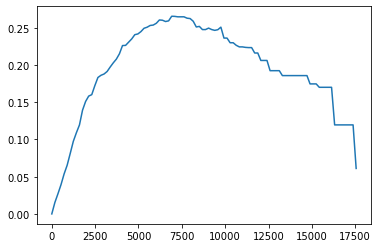

In [35]:
time_grid = np.linspace(Time_test.min(), Time_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

 The Brier score is used to evaluate the accuracy of a predicted survival function at a given time t

In [36]:
ev.integrated_brier_score(time_grid) #brier_score

0.1947794578177152

In [37]:
ev.integrated_nbll(time_grid) #binomial log-likelihood

0.5702935667120325

In [38]:
surv.iloc[:, :5]

,0,1,2,3,4
0.491054,1.000000,1.000000,1.000000,1.000000,1.000000
0.494233,1.000000,1.000000,1.000000,1.000000,1.000000
0.651389,1.000000,1.000000,1.000000,1.000000,1.000000
0.781283,1.000000,1.000000,1.000000,1.000000,1.000000
0.868685,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...
15369.979835,0.251009,0.297408,0.200499,0.359396,0.274506
16001.578398,0.251009,0.297408,0.200499,0.359396,0.274506
16130.963762,0.251009,0.297408,0.200499,0.359396,0.274506
17482.899965,0.251009,0.297408,0.200499,0.359396,0.274506


In [193]:
import copy
df_train = pd.read_excel("SimData_Transplant_Ver2.0.xls", index_col = False, header=0)
df_train = df_train[df_train['Age_Tx'] >= 18] 
le = LabelEncoder()
df_train["Gender"] = le.fit_transform(df_train["Gender"])
df_train["Bloodtype"] = le.fit_transform(df_train["Bloodtype"])
df_train["Donor_Bloodtype"] = le.fit_transform(df_train["Donor_Bloodtype"])
df_train["Inpt_attx"] = le.fit_transform(df_train["Inpt_attx"])
df_train["Donor_Sex"] = le.fit_transform(df_train["Donor_Sex"])
df_train["Donor_DCD"] = le.fit_transform(df_train["Donor_DCD"])
feature_df_train = copy.deepcopy(df_train)

In [194]:
y_time = feature_df_train['Time']
y_cens = feature_df_train['Cens']
feature_df_train = df_train.drop(['Time', 'Cens'], axis=1)

In [195]:
feature_df_train

,Gender,Bloodtype,Inpt_attx,Donor_Sex,Donor_Bloodtype,Donor_DCD,Waittime,Age_Tx,Donor_Age,TransplantBMI,Donor_BMI,MELD,MELDNA
0,1,3,2,1,2,0,1,54.291739,45.379636,24.712049,21.369229,22.939930,22.931727
1,1,0,0,1,3,0,157,59.817111,60.516200,28.887631,25.408853,18.985337,21.381548
2,0,0,0,1,0,0,49,63.198440,30.989861,26.869533,24.902931,23.694392,26.243047
3,1,3,2,0,2,0,81,28.845900,41.142174,27.411596,35.396950,11.375444,8.545730
4,1,3,0,0,3,0,620,55.523918,49.138937,24.530967,29.372668,26.835544,29.211865
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,0,0,0,0,0,638,66.768544,62.181956,29.624822,30.205990,17.050266,14.632579
3996,1,0,0,1,0,0,146,61.143847,57.131994,24.984602,18.078771,13.369472,10.730959
3997,1,0,2,0,0,0,60,41.818547,39.402747,31.146902,24.720377,19.096785,22.031645
3998,1,0,0,1,0,0,152,36.732881,18.422351,36.196905,22.702255,16.906836,14.620845


In [196]:
mytype=np.dtype([('Status', '?'), ('Survival_in_days', '<f8')])
data_y = np.zeros(4000,dtype=mytype)
for i in range(len(y_time)):
    data_y[i][0] = y_cens[i]
    data_y[i][1] = y_time[i]
data_y

array([(False, 2019.86696186), ( True, 1815.12806469),
       (False,  396.55620022), ..., (False, 3091.40556575),
       (False, 1833.62266184), (False, 4786.39621849)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [198]:
import numpy as np
from sksurv.metrics import concordance_index_censored
from sksurv.nonparametric import kaplan_meier_estimator
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(feature_df_train, data_y)

CoxPHSurvivalAnalysis()

In [199]:
pd.Series(estimator.coef_, index=feature_df_train.columns)

Gender            -0.136979
Bloodtype         -0.015777
Inpt_attx          0.123343
Donor_Sex          0.185871
Donor_Bloodtype    0.061373
Donor_DCD          0.223080
Waittime           0.000124
Age_Tx             0.004782
Donor_Age         -0.004533
TransplantBMI     -0.002161
Donor_BMI          0.005802
MELD              -0.005774
MELDNA            -0.007587
dtype: float64

In [200]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(feature_df_train)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_days"], prediction)
result[0]

0.5628222290159716

 fit a Cox model to each variable individually and record the c-index on the training set.

In [201]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(feature_df_train.values, data_y)
pd.Series(scores, index=feature_df_train.columns).sort_values(ascending=False)

Donor_Sex          0.526823
MELD               0.523983
Donor_Bloodtype    0.523939
MELDNA             0.523209
Donor_Age          0.521975
Age_Tx             0.521367
Bloodtype          0.517323
Waittime           0.513090
Donor_BMI          0.512790
Inpt_attx          0.511537
Gender             0.509103
TransplantBMI      0.507212
Donor_DCD          0.504694
dtype: float64

In [203]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline([('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

from sklearn.model_selection import GridSearchCV, KFold

param_grid = {'select__k': np.arange(1, feature_df_train.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(feature_df_train, data_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
12,13,{'select__k': 13},0.532464,0.518611,0.564014,0.538363,0.018999,1,0.569175,0.577692,0.557767,0.568211,0.008163
11,12,{'select__k': 12},0.527315,0.518293,0.563388,0.536332,0.019483,2,0.568783,0.577778,0.557565,0.568042,0.008269
10,11,{'select__k': 11},0.527037,0.504159,0.562591,0.531262,0.024041,3,0.568578,0.576059,0.557846,0.567494,0.007475
7,8,{'select__k': 8},0.526460,0.517054,0.545585,0.529700,0.011871,4,0.568983,0.570432,0.556107,0.565174,0.006439
9,10,{'select__k': 10},0.525730,0.508867,0.550543,0.528380,0.017117,5,0.568951,0.574540,0.558496,0.567329,0.006650
8,9,{'select__k': 9},0.524105,0.508495,0.550072,0.527557,0.017148,6,0.566118,0.573506,0.558560,0.566061,0.006102
6,7,{'select__k': 7},0.512869,0.516152,0.538045,0.522355,0.011175,7,0.566101,0.570328,0.551305,0.562578,0.008156
5,6,{'select__k': 6},0.499361,0.515550,0.538123,0.517678,0.015896,8,0.563117,0.568884,0.550725,0.560909,0.007576
2,3,{'select__k': 3},0.498850,0.519518,0.527131,0.515166,0.011949,9,0.547906,0.561121,0.549616,0.552881,0.005868
4,5,{'select__k': 5},0.501155,0.507187,0.536296,0.514879,0.015343,10,0.558375,0.565761,0.549882,0.558006,0.006488


In [206]:
pipe.set_params(**gcv.best_params_)
pipe.fit(feature_df_train, data_y)

transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=feature_df_train.columns[transformer.get_support()])

Gender            -0.136979
Bloodtype         -0.015777
Inpt_attx          0.123343
Donor_Sex          0.185871
Donor_Bloodtype    0.061373
Donor_DCD          0.223080
Waittime           0.000124
Age_Tx             0.004782
Donor_Age         -0.004533
TransplantBMI     -0.002161
Donor_BMI          0.005802
MELD              -0.005774
MELDNA            -0.007587
dtype: float64